# Low-resolution (multi-cellular) dataset
Apr 2025

For low-resolution (multi-cellular level) spatially resolved transcriptomics dataset.

The dataset is available at:
* Slide-seq mouse embryonic neocortex data
* https://singlecell.broadinstitute.org/single_cell/study/SCP815/sensitive-spatial-genomewide-expression-proﬁling-at-cellular-resolution#study-download

## Part I. Infer the network

In [1]:
# Load SpaGRN and dependencies
import os
import sys

import argparse
import pandas as pd
import scanpy as sc
from multiprocessing import cpu_count

from spagrn.regulatory_network import InferNetwork as irn

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/Oreo/anaconda3/envs/spagrn/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### 1. Load in data
**Essential data:**<br>
Spatially resolved transcriptomics data: the matrix of gene expression for each single cell. Each column represents a gene, and each row represents a SRT sample. Values in the matrix are typically gene expression levels, either raw counts or normalized expression (raw counts prefered). 

In [ ]:
fn = 'mouse_brain_E15.h5ad'  # mouse_brain slide_seq data      
data = irn.read_file(fn)
print(data)

AnnData object with n_obs × n_vars = 19269 × 3235
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances'


#### Preprocess Data:
Perform cleaning and quality control on the imported data before constructing the gene regulatory network.
1. filter spots/cells with less than min_genes number of genes expressed;
2. keep genes that have at least min_counts counts or are expressed in at least min_cells cells;
3. keep spots/cells with no more than max_genes number of genes;

In [7]:
data = irn.preprocess(data, min_genes=10, min_cells=3, min_counts=10, max_gene_num=4000)
print(data)

View of AnnData object with n_obs × n_vars = 19269 × 3235
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'n_counts'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_counts'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances'


#### Visualize Data

/Users/Oreo/anaconda3/envs/spagrn/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


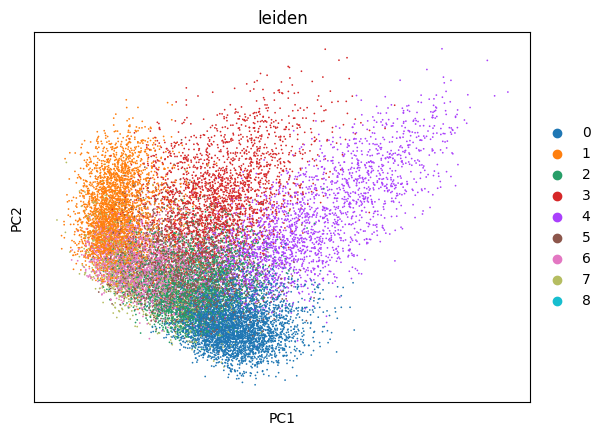

In [9]:
sc.tl.pca(data)
sc.pl.pca(data, color='leiden')

#### Load other necessary data
**Auxilliary datasets:**<br>
Transcription factor gene list: a list of transcription factors of interest. This list is requried for the network inference step. Data can be downloaded through pySCENIC_TF_list and TF_lists.

Ranked whole genome databases: Databases ranking the whole genome of species of interest based on transcription factors in feather v2 format. Data can typically be downloaded from public databases, through cisTarget databases.

Motif to TF annotation databases: Motif databases (in tbl format) serve as a reference for identifying potential TF binding sites in the genome and inferring the regulatory relationships between TFs and target genes. Data can be downloaded through Motif2TF annotations.

In [10]:
tfs_fn = 'mouse_tfs.txt'
database_fn = 'mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'
motif_anno_fn = 'motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl'

### 2. Create a spagrn object
pos_label is the obsm key where spots coordinates were stored.

In [ ]:
grn = irn(data, project_name='mouse_brain')

[optional] set parameters of the model:
1. rank_threshold: number of ranked genes;
2. prune_auc_threshold: fraction of the ranked genome when computing AUC in prune modules step;
3. nes_threshold: normalized enrichment score (nes) threshold to select enriched motifs;
4. auc_threshold: fraction of the ranked genome when computing AUC;

In [12]:
grn.add_params({'prune_auc_threshold': 0.05, 'rank_threshold': 9000, 'auc_threshold': 0.05})

### 3. Set Ligand-Receptor data
Pre-computed ligand-recpetor datasets obtained from CellPhoneDB.

In [13]:
niche_human = pd.read_csv('lr_network_human.csv')
niche_mouse = pd.read_csv('lr_network_mouse.csv')
# concat the databases together if you are using multiple ligand-receptors databases
niches = pd.concat([niche_mouse, niche_human])
print(niches)

               from      to  database    source
0     2300002M23Rik    Ddr1  omnipath  omnipath
1     2610528A11Rik   Gpr15  omnipath  omnipath
2     9530003J23Rik   Itgal  omnipath  omnipath
3                 a    Atrn  omnipath  omnipath
4                 a    F11r  omnipath  omnipath
...             ...     ...       ...       ...
4981          ZNRF3    FZD4  omnipath  omnipath
4982            ZP3    EGFR  omnipath  omnipath
4983            ZP3  CHRNA7  omnipath  omnipath
4984            ZP3   MERTK  omnipath  omnipath
4985          ZPBP2    CD80  omnipath  omnipath

[10654 rows x 4 columns]


### 4. Construct the network
In order to construct a GRN:
- database_fn
- motif_anno_fn
- niche_df
- gene_list: A list of interested genes to calculate co-expression values with TF genes. e.g. a list of HVGs.

- num_workers: number of thread.
- cache: if use saved intermediate result files.
- output_dir: output directory.
- save_tmp: if save intermediate results onto disk.

- layer_key: Key in adata.layers with count data, uses adata.X if None.
- latent_obsm_key: Key in adata.obsm where cell/spot coordinates are.
- cluster_label: Key in adata.obs with cluster/cell type labels.

- model: Specifies the null model to use for gene expression.
- n_neighbors: n cell/spots to consider as "neighbors" when computing spatial autocorrelation and gene co-expression.
- methods: a list of spatial autocorrelation statistics, options are 'FDR_C', 'FDR_I', 'FDR_G', 'FDR'.
- operation: options are 'intersection' and 'union'.
- mode: bi-variate Geary's C or bi-variate Moran's R when computing gene co-expression. options are 'moran' and 'geary'.

In [ ]:
grn.infer(database_fn,
          motif_anno_fn,
          tfs_fn,
          niche_df=niches,
          gene_list=None,
          num_workers=20,
          cache=True,
          output_dir='exp/ouput',
          save_tmp=True,
          layers='raw_counts',
          latent_obsm_key='spatial',
          model='bernoulli',
          n_neighbors=10,
          methods=['FDR_I','FDR_C','FDR_G'],
          operation='intersection',
          mode='moran',
          cluster_label='leiden')

100%|████████████████████████████████████████████████████████████████████████████████| 3235/3235 [00:11<00:00, 280.82it/s]


Computing spatial weights matrix...
Computing Moran's I...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested

KeyboardInterrupt: 

## Part II. Interpreting the results
The results of Gene Regulatory Network were stored in an AnnData object.

In [ ]:
adata = sc.read_h5ad('spg_spagrn_gearyc.h5ad')
adata

AnnData object with n_obs × n_vars = 50140 × 23472
    obs: 'annotation', 'n_genes', 'n_counts'
    var: 'Gene', 'n_cells', 'n_counts'
    uns: 'adj', 'annotation_colors', 'method', 'pca', 'receptor_dict_all', 'receptors', 'receptors_all', 'regulon_dict', 'rss'
    obsm: 'X_pca', 'auc_mtx', 'isr', 'rep_auc_mtx', 'spatial'
    varm: 'PCs'
    layers: 'counts'

Regulons were stored in adata.uns under key `regulon_dict` in dictionary format.

In [ ]:
adata.uns['regulon_dict']

{'Atf2(+)': array(['Atp2b1', 'Atf2', 'Galnt13', 'Ube3a', 'Lrrc7', 'Adgrl3', 'Syt1',
        'Sgcz', 'Akt3', 'Pafah1b1', 'Foxp1', 'Basp1', 'Hivep2', 'Elavl2',
        'Stmn2', 'Rims2', 'Gphn', 'Stxbp5l', 'Kansl1', 'Cnksr2', 'Pja2',
        'Tanc2', 'Mef2a', 'Grid2', 'Meg3', 'Fam19a2', 'Lingo2', 'Atxn1',
        'Cdkl5', 'Sept7', 'Zfp385b', 'Zfp804a', 'Ntng1', 'Sntg1', 'R3hdm1',
        'Ppp3cb', 'Epha6', 'Cdh8', 'Nlgn1', 'Rora', 'Zfr', 'Ttc3', 'Fgf12',
        'Oxr1', 'Lrrc4c', 'Prr16', 'Dlgap1', 'Ptpn4', 'Arhgap21', 'Nbea',
        'Camk2d', 'Lrfn5', 'Myh10', 'Gabrb2', 'Ralyl', 'Magi1', 'Kcnt2',
        'Apba2', 'Frmpd4', 'Grm5', 'Cntn1', 'Ccser1', 'Kif1a', 'Nrn1',
        'Kcnc2', 'Tenm4', 'Inpp4b', 'Bcl11a', 'Kcnj3', 'Vsnl1', 'Adgrb3',
        'Pak3', 'Cadm3', 'Osbpl6', 'Ncor1', 'Dok6', 'Wdfy3', 'Efna5',
        'Gria4', 'Peak1', 'Chsy3', 'Pam', 'Syndig1', 'Hecw1', 'Dpp10',
        'Ppp3ca', 'Tmeff2', 'Arpp21', 'Gria2', 'Herc1', 'Snap25',
        'Cacna2d1', 'Kif1b', 'Anks1b', 'Lmo4'

Receptors of each regulon were stored in adata.uns under key `receptor_dict` in dictionary format.

In [ ]:
adata.uns['receptor_dict']

{'Atf2': array(['Scn2a', 'Scn1a', 'Dscam', 'Cacna1b', 'Lrrtm4', 'Cacna1c', 'Ntm',
        'Atp1a3', 'Il31ra', 'Nrsn1', 'Il1rapl1', 'Scn2b', 'Opcml', 'Sv2b',
        'Stx1a', 'Adam23'], dtype=object),
 'Atf4': array(['Gp1bb', 'Thy1', 'Nptn', 'Rtn4', 'Nptxr', 'Sv2b', 'Stx1a', 'App',
        'Lingo1'], dtype=object),
 'Bcl11a': array(['Gp1bb', 'Sirpa', 'Scn2a', 'Tyro3', 'Dscam', 'Scn1b', 'Il1rapl1',
        'Lrp11', 'Opcml', 'Sv2b', 'Stx1a', 'Tmem59l'], dtype=object),
 'Bcl6': array(['Ptprt', 'F3', 'Mertk'], dtype=object),
 'Bnc2': array(['Mrc2', 'Thbd', 'Tgfbr3', 'Asgr1', 'Anxa2', 'Cd36', 'Slc6a12'],
       dtype=object),
 'Cebpb': array(['Neurod2', 'C1ql2', 'Olfm1', 'Ppp3ca', 'Hpca', 'Rfx3', 'Snca',
        'Wasf1', 'Sema5a', 'Prox1', 'Calm2', 'Ppfia2', 'Bex2', 'Camk2b',
        'Pter', 'C1ql3', '2010300C02Rik', 'Dsp', 'Ppp1r1a', 'Nrgn',
        'Cpne6', 'Chn1', 'Dgkh', 'Dynll1', 'Rps7', 'Cebpb', 'Tmsb4x',
        'Ncdn'], dtype=object),
 'Cebpd': array(['Grin2a', 'Adcy1', 'Crlf1'], dty

ISR matrix (n cells x m regulons) was stored in adata.obsm under key `isr` in pd.Dataframe format.

In [ ]:
adata.obsm['isr']

,Atf2(+),Atf4(+),Bcl11a(+),Bcl6(+),Bnc2(+),Cebpb(+),Cebpd(+),Dbp(+),Dlx1(+),Ebf1(+),...,Satb2(+),Sox10(+),Sox9(+),Srebf1(+),Tbx18(+),Tcf4(+),Tcf7l2(+),Thra(+),Thrb(+),Vsx1(+)
Cell,,,,,,,,,,,,,,,,,,,,,
Cell_1,0.156431,0.111644,0.098457,0.000000,0.033453,0.085540,0.000000,0.170651,0.122474,0.000000,...,0.099124,0.030581,0.043982,0.108448,0.000000,0.282513,0.121834,0.123972,0.103947,0.0
Cell_1000,0.212292,0.218080,0.164389,0.053236,0.056976,0.215377,0.060005,0.180853,0.053370,0.000000,...,0.124200,0.023578,0.023990,0.059154,0.000000,0.368584,0.047002,0.218843,0.112490,0.0
Cell_10000,0.111001,0.060451,0.075737,0.000000,0.032233,0.107542,0.000000,0.134629,0.040831,0.000000,...,0.079151,0.021887,0.069703,0.349720,0.000000,0.320939,0.076905,0.085574,0.074182,0.0
Cell_10001,0.081370,0.148219,0.101323,0.086841,0.028692,0.177124,0.000000,0.187842,0.034786,0.000000,...,0.062423,0.040046,0.135491,0.336981,0.000000,0.172192,0.035783,0.144633,0.052906,0.0
Cell_10002,0.139363,0.371802,0.186718,0.074740,0.000000,0.286048,0.000000,0.324644,0.075673,0.075543,...,0.104446,0.040820,0.137917,0.359795,0.000000,0.311838,0.066502,0.279441,0.090039,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell_9994,0.081529,0.192922,0.121566,0.000000,0.011434,0.107356,0.000000,0.079788,0.091360,0.000000,...,0.072796,0.048270,0.059478,0.116394,0.000000,0.124870,0.011098,0.116962,0.060993,0.0
Cell_9996,0.253249,0.273179,0.174062,0.058310,0.078524,0.259639,0.000000,0.178899,0.204684,0.163190,...,0.140081,0.041906,0.123377,0.315487,0.000000,0.347189,0.114236,0.220211,0.146768,0.0
Cell_9997,0.190197,0.204892,0.185552,0.089932,0.016441,0.182882,0.052197,0.216455,0.096070,0.000000,...,0.139947,0.031018,0.139405,0.583368,0.000000,0.314701,0.095673,0.242292,0.116345,0.0


## Part III. Visualization of the network

In [25]:
import spagrn.plot as prn

### Regulon 2D spatially distribution plot
`plot_2d` plots the spatial distribution of the regulon activity level, with each point representing a spatial location and the color indicating the ISR value of the corresponding regulon.

In [29]:
%matplotlib inline
prn.plot_2d(adata, adata.obsm['auc_mtx'], pos_label='spatial', reg_name='Pbx3', fn='Pbx3.png')

<img src="Pbx3.png">

### Heatmaps
`auc_heatmap` visualize the activity levels of regulons across cells, allowing for easy comparison and identification of trends or patterns. By clustering the cells based on regulon activities, one can see whether there are groups of cells that tend to have the same regulons active, and reveal the network states that are recurrent across multiple cells.
#### 1. regular heatmap

In [ ]:
prn.auc_heatmap(data,
                auc_mtx,
                cluster_label='annotation',
                topn=10,
                subset=False,
                save=True,
                fn=f'{out_dir}/{method}_clusters_heatmap_top10.png',
                legend_fn=f"{out_dir}/{method}_rss_celltype_legend_top10.png")